# Level Generation using Generative Adversarial Networks





First lets import all the libraries we are going to need

In [1]:
# Deep Learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

# Utils
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image

# Check if CUDA is available, If you are sure you have a CUDA GPU check your install of pytorch is correct.
print(f"CUDA Available:{torch.cuda.is_available()}")

CUDA Available:True


Now we are going to define two classes, the Generator and Discriminator.

In [2]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [3]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(channels_noise, features_g * 16, 4, 1, 0),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1), 
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

The next two methods are helpers for the model.

The **initialise_weights** method is used to set the inital weight values for the models.

The **gradient_penalty** method is the extra part ontop of the GAN which will help produce better results.

In [4]:
def initialise_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate dis scores
    mixed_scores = dis(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

The next part is where we train the WGAN-GP. We sont have access to the same dataset the researchers used so we only have 62 example images to train off. although this is not ideal you will still have an understanding of how it works and see some results.

We will be using the floormap data for this example.

In [5]:
# Set device to use
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using Device: {device}")

# Hyperparameters
LEARNING_RATE = 5e-5
BATCH_SIZE = 8
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 2000
FEATURES_DIS = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10
BATCH_M_ONE = BATCH_SIZE - 1

transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(IMAGE_SIZE),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),
    ]
)

# Load in data from folder
dataset = torchvision.datasets.ImageFolder('./doom-levels/output/floormap', transform=transforms)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# initialize gen and disc
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
dis = Discriminator(CHANNELS_IMG, FEATURES_DIS).to(device)
initialise_weights(gen)
initialise_weights(dis)

# Initializate optimisers
opt_gen = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)
opt_dis = optim.RMSprop(dis.parameters(), lr=LEARNING_RATE)

# Tensorboard plotting
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/WGAN_GP/real")
writer_fake = SummaryWriter(f"logs/WGAN_GP/fake")
step = 0

# Train models
gen.train()
dis.train()

# Used to plot loss over epochs
G_loss = []
D_loss = []

epoch_range=range(NUM_EPOCHS)

# For timing total runtime
time_zero = time.time()

# Training loop
for epoch in epoch_range:
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Train dis: max E[dis(real)] - E[dis(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            dis_real = dis(real).reshape(-1)
            dis_fake = dis(fake).reshape(-1)
            gp = gradient_penalty(dis, real, fake, device=device)
            loss_dis = (-(torch.mean(dis_real) - torch.mean(dis_fake)) + LAMBDA_GP * gp)
            dis.zero_grad()
            loss_dis.backward(retain_graph=True)
            opt_dis.step()

        # Train Generator: max E[dis(gen_fake)] <-> min -E[dis(gen_fake)]
        gen_fake = dis(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print loss and output to tensorboard
        if batch_idx % BATCH_M_ONE == 0 and batch_idx > 0:
            if epoch % 10 == 0:
                print(
                    f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                    Loss D: {loss_dis:.4f}, loss G: {loss_gen:.4f}"
                )

            # Store losses
            G_loss.append(loss_gen.item())
            D_loss.append(loss_dis.item())

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                # Saves sample images at the end
                if epoch == NUM_EPOCHS - 1:
                    save_image(img_grid_real, f"samples/epoch_real_{epoch}.png")
                    save_image(img_grid_fake, f"samples/epoch_fake_{epoch}.png")

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

duration = time.time() - time_zero
print('Ran in: {:.2f} seconds'.format(duration))

Using Device: cuda
Epoch [0/2000] Batch 7/8                     Loss D: -3.6295, loss G: 2.3740
Epoch [10/2000] Batch 7/8                     Loss D: -55.3953, loss G: 28.3380
Epoch [20/2000] Batch 7/8                     Loss D: -103.1381, loss G: 52.3505
Epoch [30/2000] Batch 7/8                     Loss D: -147.8210, loss G: 76.6327
Epoch [40/2000] Batch 7/8                     Loss D: -182.1353, loss G: 99.1267
Epoch [50/2000] Batch 7/8                     Loss D: -210.9335, loss G: 119.5197
Epoch [60/2000] Batch 7/8                     Loss D: -234.3560, loss G: 136.9306
Epoch [70/2000] Batch 7/8                     Loss D: -233.7992, loss G: 149.0563
Epoch [80/2000] Batch 7/8                     Loss D: -250.4393, loss G: 162.2995
Epoch [90/2000] Batch 7/8                     Loss D: -230.5706, loss G: 170.6191
Epoch [100/2000] Batch 7/8                     Loss D: -225.1426, loss G: 175.8247
Epoch [110/2000] Batch 7/8                     Loss D: -211.5143, loss G: 177.0337
Epoch

Once the training has completed we can take a look at the results by generating an image from noise using the trained model like so

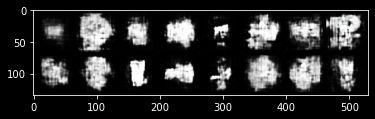

In [8]:
# Generate a new images from noise
fake = gen(fixed_noise)

# Plot images
example_grid_fake = torchvision.utils.make_grid(fake[:16], normalize=True)
plt.figure()
plt.imshow(example_grid_fake.cpu().permute([1,2,0]))
plt.show()

As you can see we have some images that genrally look like some of the levels we used before. Unfortuanly we don't have the 1000+ dataset the researchers used so this GAN is only able to train off 62 examples. With more examples to train off the results would look a lot better.

This next step is optional, it allows you to save the model state to recall another time

In [ ]:
# Save Model
torch.save({
            'gen_state_dict': gen.state_dict(),
            'dis_state_dict': dis.state_dict(),
            'opt_gen_state_dict': opt_gen.state_dict(),
            'opt_dis_state_dict': opt_dis.state_dict()
            }, f"./model/model_epoch({NUM_EPOCHS})_date({datetime.datetime.utcnow().replace(microsecond=0).isoformat().replace('-', '_').replace(':', '_')}).pth")

We can see the progress of our model by looking at the loss value over each epoch. Usually the loss value of a GANs does not mean much but with a WGAN-GP it can give us an indication as to how the model performed as its loss function is different.

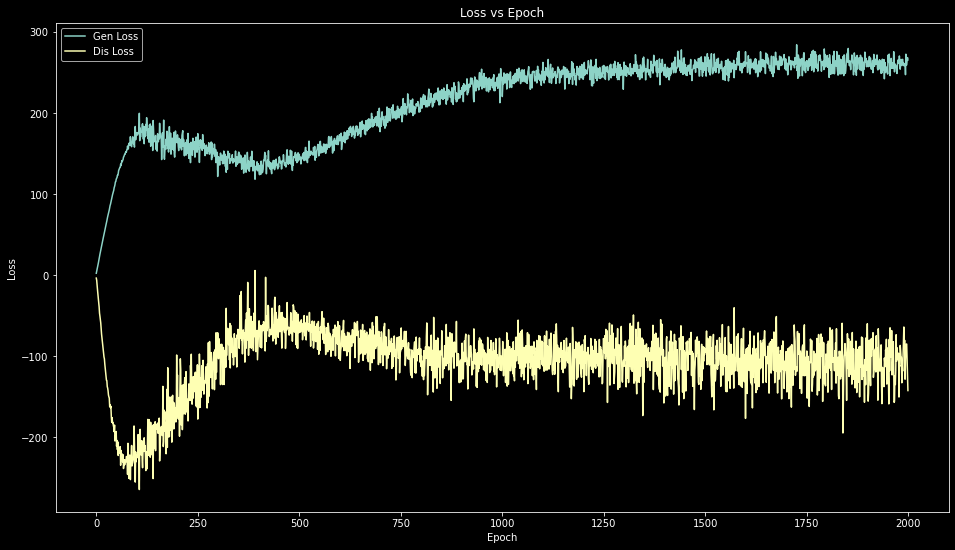

In [9]:
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(epoch_range, G_loss, label = "Gen Loss")
plt.plot(epoch_range, D_loss, label = "Dis Loss")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

As you can see after the networks reach their peak loss values they begin to decay back and start to vary significantly as training progresses. This is in part due to the lack of data availabe for the model to train off.